# Initialization

In [1]:
from cbrain.imports import *
from cbrain.data_generator import *
from cbrain.cam_constants import *
from cbrain.losses import *
from cbrain.utils import limit_mem
from cbrain.layers import *
from cbrain.data_generator import DataGenerator
import tensorflow as tf
import tensorflow.math as tfm
#import tensorflow_probability as tfp
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import xarray as xr
import numpy as np
from cbrain.model_diagnostics import ModelDiagnostics
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as imag
import scipy.integrate as sin
import cartopy.crs as ccrs
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import pickle

# Otherwise tensorflow will use ALL your GPU RAM for no reason
limit_mem()

/data11/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog


# Libraries

In [2]:
def dP(PS):    
    S = PS.shape
    P = 1e5 * np.moveaxis(np.tile(hyai,(S[0],S[1],S[2],1)),3,1) + \
    np.moveaxis(np.tile(PS.values,(31,1,1,1)),0,1) * np.moveaxis(np.tile(hybi,(S[0],S[1],S[2],1)),3,1)
    return P[:, 1:]-P[:, :-1]

In [3]:
# Moist thermo library in numpy
def eliq(T):
    a_liq = np.array([-0.976195544e-15,-0.952447341e-13,0.640689451e-10,0.206739458e-7,0.302950461e-5,0.264847430e-3,0.142986287e-1,0.443987641,6.11239921]);
    c_liq = -80
    T0 = 273.16
    return 100*np.polyval(a_liq,np.maximum(c_liq,T-T0))

def eice(T):
    a_ice = np.array([0.252751365e-14,0.146898966e-11,0.385852041e-9,0.602588177e-7,0.615021634e-5,0.420895665e-3,0.188439774e-1,0.503160820,6.11147274]);
    c_ice = np.array([273.15,185,-100,0.00763685,0.000151069,7.48215e-07])
    T0 = 273.16
    return (T>c_ice[0])*eliq(T)+\
(T<=c_ice[0])*(T>c_ice[1])*100*np.polyval(a_ice,T-T0)+\
(T<=c_ice[1])*100*(c_ice[3]+np.maximum(c_ice[2],T-T0)*(c_ice[4]+np.maximum(c_ice[2],T-T0)*c_ice[5]))    

def esat(T):
    T0 = 273.16
    T00 = 253.16
    omega = np.maximum(0,np.minimum(1,(T-T00)/(T0-T00)))
    
    return (T>T0)*eliq(T)+(T<T00)*eice(T)+(T<=T0)*(T>=T00)*(omega*eliq(T)+(1-omega)*eice(T))

def RH(T,qv,P0,PS,hyam,hybm):
    R = 287
    Rv = 461
    p = (hyam*P0+hybm*PS).values # Total pressure (Pa)

    return Rv*p*qv/(R*esat(T))

def RHsurf(T,qv,P0,PS):
    R = 287
    Rv = 461
    
    return Rv*PS*qv/(R*esat(T))

def qv(T,RH,P0,PS,hyam,hybm):
    R = 287
    Rv = 461
    p = (hyam*P0+hybm*PS).values # Total pressure (Pa)
    
    return R*esat(T)*RH/(Rv*p)

def qsat(T,P0,PS,hyam,hybm):
    return qv(T,1,P0,PS,hyam,hybm)

In [4]:
def edg2bin(bin_edges):
    return 0.5*(bin_edges[1:]+bin_edges[:-1])

# Load data

In [7]:
#path = '/project/meteo/w2w/A6/S.Rasp/SP-CAM/sp8fbp_minus4k/sp8fbp_minus4k.cam2.h2.'
path = '/DFS-L/DATA/pritchard/tbeucler/SPCAM/sp8fbp_minus4k/sp8fbp_minus4k.cam2.h2.'
# datam4K = xr.open_mfdataset(path+'0001-01-0?-00000.nc',\
#                           decode_times=False)
datam4K = xr.open_mfdataset(path+'0001-01-05-00000.nc',\
                          decode_times=False)

ERROR! Session/line number was not unique in database. History logging moved to new session 28


In [8]:
#path = '/project/meteo/w2w/A6/S.Rasp/SP-CAM/sp8fbp_4k/sp8fbp_4k.cam2.h2.'
path = '/DFS-L/DATA/pritchard/tbeucler/SPCAM/sp8fbp_4k/sp8fbp_4k.cam2.h2.'
# datap4K = xr.open_mfdataset(path+'0001-01-0?-00000.nc',\
#                            decode_times=False)
datap4K = xr.open_mfdataset(path+'0001-01-05-00000.nc',\
                           decode_times=False)

In [9]:
path = '/DFS-L/DATA/pritchard/tbeucler/SPCAM/fluxbypass_aqua/AndKua_aqua_SPCAM3.0_sp_fbp_f4.cam2.h1.'
# dataref = xr.open_mfdataset(path+'0001-01-0?-00000.nc',\
#                            decode_times=False)
dataref = xr.open_mfdataset(path+'0001-01-05-00000.nc',\
                           decode_times=False)

# Check Ankitesh's discrete and continuous tropopause pressure

## Functions developed by Ankitesh

In [22]:
def levTildeDiscrete(X,lev,inp_sub,inp_div,batch_size=1024,interm_dim_size=40):
    
    X_denormalized = X*inp_div+inp_sub
    X_pressure = X[:,:30]
    X_temperature = X[:,30:60] #batchx30
    X_temperature_denomalized = X_denormalized[:,30:60]
    
    lev_stacked = lev_stacked = np.repeat(np.array(lev).reshape(1,-1),batch_size,axis=0)
    imin = np.argmin(X_temperature_denomalized[:,6:],axis=1)+6
    lev_roof = np.array(lev[imin])
    lev_tilde = (lev_stacked[:,-1].reshape(-1,1)-lev_stacked[:])/(lev_stacked[:,-1].reshape(-1,1)-lev_roof.reshape(-1,1))#batchx30

    
    lev_tilde_after_single = np.linspace(1.4,0,num=interm_dim_size)
    
    X_temperature_after = []
    X_pressure_after = []

    for i in range(batch_size):
        X_temperature_after.append(np.interp(lev_tilde_after_single, np.flip(lev_tilde[i]), np.flip(X_temperature[i])))
        X_pressure_after.append(np.interp(lev_tilde_after_single, np.flip(lev_tilde[i]), np.flip(X_pressure[i])))
    
    X_temperature_after = np.array(X_temperature_after)
    X_pressure_after = np.array(X_pressure_after)
    
    X_result = np.hstack((X_pressure_after,X_temperature_after))
    X_result = np.hstack((X_result,X[:,60:64]))
    
    return  X_result, lev_tilde, lev_roof

In [11]:
def levTildeConti(X,lev,inp_sub,inp_div,batch_size=1024,interm_dim_size=40,Tnot=5):
    
    X_denormalized = X*inp_div+inp_sub
    X_pressure = X[:,:30]
    X_temperature = X[:,30:60] #batchx30
    X_temperature_denormalized = X_denormalized[:,30:60]
    lev_stacked = lev_stacked = np.repeat(np.array(lev).reshape(1,-1),batch_size,axis=0)
    imin = np.argmin(X_temperature_denormalized[:,6:],axis=1)+6 #take one below this and the next one
    lev1 = np.array(lev[imin-1]) #batch_size dim
    lev2 = np.array(lev[imin+1])
    T1 = np.take_along_axis( X_temperature_denormalized, (imin-1).reshape(-1,1),axis=1).flatten() ## batch_size
    T2 = np.take_along_axis( X_temperature_denormalized, (imin+1).reshape(-1,1),axis=1).flatten() ## batch_size    
    deltaT = T2-T1
    alpha = (1.0/2)*(2 - np.exp(-1*deltaT/Tnot))
    lev_roof = alpha*lev1 + (1-alpha)*lev2
    
    lev_tilde = (lev_stacked[:,-1].reshape(-1,1)-lev_stacked[:])/(lev_stacked[:,-1].reshape(-1,1)-lev_roof.reshape(-1,1))#batchx30
    lev_tilde_after_single = np.linspace(1.4,0,num=interm_dim_size)
    
    X_temperature_after = []
    X_pressure_after = []

    for i in range(batch_size):
        X_temperature_after.append(np.interp(lev_tilde_after_single, np.flip(lev_tilde[i]), np.flip(X_temperature[i])))
        X_pressure_after.append(np.interp(lev_tilde_after_single, np.flip(lev_tilde[i]), np.flip(X_pressure[i])))
    
    X_temperature_after = np.array(X_temperature_after)
    X_pressure_after = np.array(X_pressure_after)
    
    X_result = np.hstack((X_pressure_after,X_temperature_after))
    X_result = np.hstack((X_result,X[:,60:64]))
    
    return  X_result, lev_tilde, lev_roof

## Transform data into right format

In [52]:
dataref.TAP.shape

(48, 30, 64, 128)

In [53]:
X = np.moveaxis(dataref.TAP.values,0,1)

In [54]:
X.shape

(30, 48, 64, 128)

In [55]:
X0 = np.reshape(X,(30,48*64*128))

In [56]:
X0.shape

(30, 393216)

In [57]:
X = np.transpose(
    np.concatenate((np.reshape(np.moveaxis(dataref.QAP.values,0,1),(30,48*64*128)),
                    np.reshape(np.moveaxis(dataref.TAP.values,0,1),(30,48*64*128))),axis=0)
)

In [58]:
X_result, lev_tilde, lev_roof = levTildeDiscrete(X,dataref.lev.values,0*X**0,1*X**0,batch_size=X.shape[0],interm_dim_size=40)

In [59]:
lev_roof.shape

(393216,)

In [60]:
lev_roof_0 = np.reshape(lev_roof,(48,64,128))

Text(0, 0.5, 'Lev roof [hPa]')

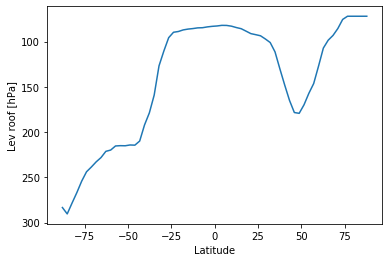

In [61]:
plt.plot(dataref.lat,np.mean(lev_roof_0,axis=(0,2)))
plt.gca().invert_yaxis()
plt.xlabel('Latitude')
plt.ylabel('Mean Lev roof [hPa]')

In [62]:
X_result, lev_tilde, lev_roof = levTildeConti(X,dataref.lev.values,0*X**0,1*X**0,batch_size=X.shape[0],interm_dim_size=40,Tnot=5)

In [63]:
lev_roof_0 = np.reshape(lev_roof,(48,64,128))

Text(0, 0.5, 'Mean Lev roof [hPa]')

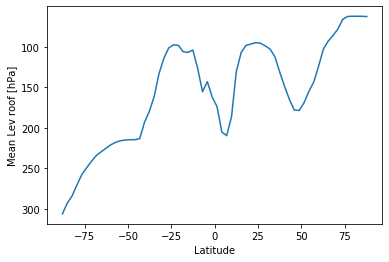

In [65]:
plt.plot(dataref.lat,np.mean(lev_roof_0,axis=(0,2)))
plt.gca().invert_yaxis()
plt.xlabel('Latitude')
plt.ylabel('Mean Lev roof [hPa]')

# Test (PW,GMS) scaling for amplitude of convective heating/moistening